--------------------
## Scenario building of the lake level


Text(0, 0.5, 'Elevation of \n lake Diefenbaker [m]')

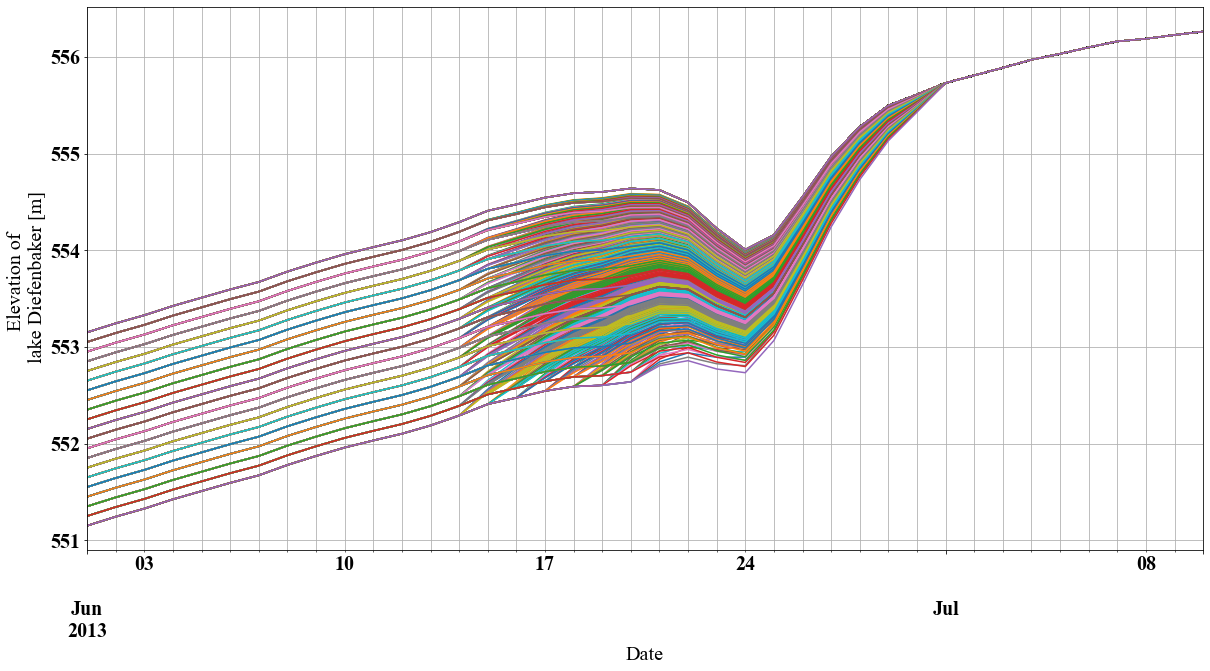

In [1]:
# load the packages
import xarray as xr
import pandas as pd
import numpy  as np
from datetime import date
from datetime import datetime
import os
import shutil
import glob
#import datetime #import date
import matplotlib.pyplot  as plt
import matplotlib
from ipynb.fs.full.Untitled2 import save_netcdf
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

# creating the target volumes for the lake Difenbaker
df = pd.read_csv('../data/05HF003.csv') # elevation record of lake diefenbaker
date_uppers = ['2013-06-26','2013-06-27','2013-06-28','2013-06-29','2013-06-30']
date_lowers = ['2013-06-14','2013-06-15','2013-06-16','2013-06-17','2013-06-18','2013-06-19','2013-06-20']
diffs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0] # start with lower values


# set the date as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

for date_upper in date_uppers:
    
    for date_lower in date_lowers:
        

        # find the time difference between larger and lower date (start and end of the action)
        d0 = datetime.fromisoformat(date_lower)
        d1 = datetime.fromisoformat(date_upper)
        delta = d1 - d0
        # print(delta.days)

        # setting the scale
        df['scale'] = 0
        df.loc[(df.index < date_lower), 'scale'] = 0
        df.loc[(df.index > date_upper), 'scale'] = 1
        df.loc[(df.index >= date_lower) & (df.index <= date_upper), 'scale'] = np.arange(delta.days+1)/(delta.days+1)

        # creating the shift colomns
        for diff in diffs:
            df ['shifted'] = df ['Value [m]'] - diff
            df ['Scenario_'+str(int(diff*10)).zfill(2)+'_'+str(d0.day)+'_'+str(d1.day)] = df ['shifted'] * (1-df['scale']) +  df ['Value [m]'] * (df['scale'])
        
df = df.drop(columns=['scale','shifted', 'Value [m]'])

# plotting
df.plot(figsize=(20,10))
plt.grid(which='both')
plt.gca().get_legend().remove()
plt.ylabel('Elevation of \n lake Diefenbaker [m]')



-----------
## Creating the target storage from the level


Text(0, 0.5, 'Storage of \n lake Diefenbaker [m3]')

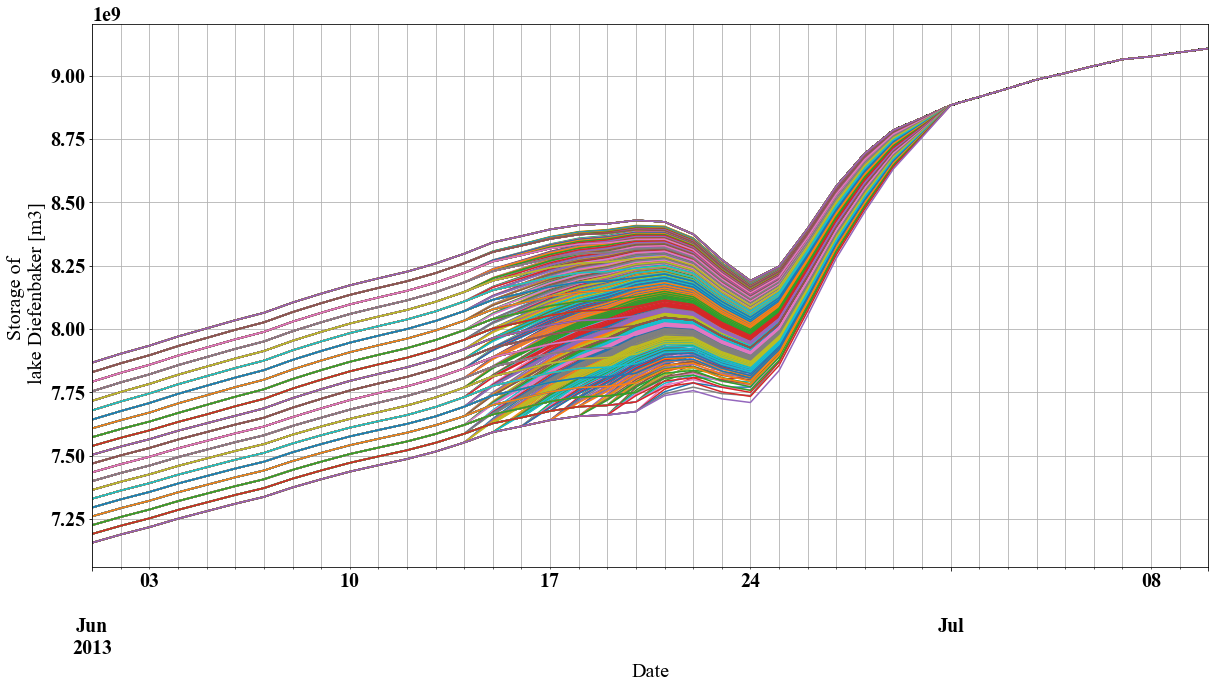

In [2]:
# load the elevation storage relationship
ele_str = pd.read_csv('../data/Storage_Elevation_Diefenbaker.csv')

df_storage = df

for column in df_storage.columns:
    df_storage [column] =    np.interp(df [column], ele_str['Elevation(m)'], ele_str['Storage(m^3)'])

# plotting
df_storage.plot(figsize=(20,10))
plt.grid(which='both')
plt.gca().get_legend().remove()
plt.ylabel('Storage of \n lake Diefenbaker [m3]')



-----------------
## saving the target volume as a separate csv files in a folder


In [3]:
path = '../data/target_storage/'
if os.path.isdir(path):
    shutil.rmtree(path)
os.mkdir(path)

# creating the water management injection/abstration data frame
dates = pd.date_range('2013-06-01','2013-07-10', freq='d')
df = pd.DataFrame(index=dates, data={'R1': 0})

# populate the colomn equal to the number of the object on network topology (16)
for i in np.arange(16):
    string = 'R'+str(i+1)
    df [string] = 0

for column in df_storage.columns:
    df ['R13'] = df_storage [column] # R13 is the model in which is located in the area
    df.to_csv (path+column+'.csv')
    # save as netcdf

file_names = glob.glob('../data/target_storage/*.csv')
for file_name in file_names:
    df = pd.read_csv(file_name)
    df.rename(columns = {'Unnamed: 0':'Dates'}, inplace = True)
    save_netcdf(df,
                'Dates',
                file_name[:-4]+'.nc',
                'Volume'+file_name[-13:-4],
                'm**3',
                'target volume',
                time_step = 'seconds', # minutes, hours, or days
                calendar = 'standard',
                ID  = None, # array of int values; numpy array
                lat = None, # array of lat values; numpy array
                lon = None, # array of lon values; numpy array
                author_name = ' ',
                case_name = ' ',
                license = ' ')


<xarray.Dataset>
Dimensions:          (time: 40, n: 16)
Coordinates:
  * time             (time) datetime64[ns] 2013-06-01 2013-06-02 ... 2013-07-10
Dimensions without coordinates: n
Data variables: (12/737)
    Volume_03_20_29  (time, n) float64 ...
    column_name      (n) object 'R1' 'R2' 'R3' 'R4' ... 'R13' 'R14' 'R15' 'R16'
    ID               (n) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    Volume_02_20_29  (time, n) float64 ...
    Volume_16_15_27  (time, n) float64 ...
    Volume_16_19_30  (time, n) float64 ...
    ...               ...
    Volume_17_19_27  (time, n) float64 ...
    Volume_17_15_30  (time, n) float64 ...
    Volume_16_19_27  (time, n) float64 ...
    Volume_16_15_30  (time, n) float64 ...
    Volume_17_18_29  (time, n) float64 ...
    Volume_16_18_29  (time, n) float64 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by  
    License:       
    History:      Created Thu Nov  4 00:14:19 2021
    Source:       Case:  ; remapp

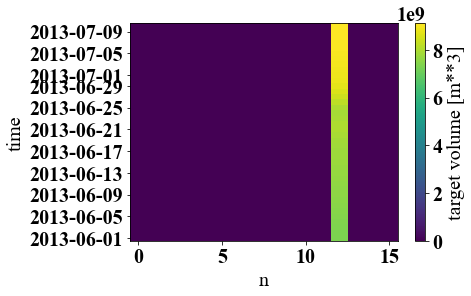

In [5]:
ds = xr.merge([xr.open_dataset(f) for f in glob.glob(path+'*.nc')])
print(ds)

ds['Volume_16_18_29'].plot()
